# **My electrophoresis sense is tingling. 🕷️ Predicting maintenance.**

---
## **Overview**
* Dataset source : E-coating ultrafiltration maintenance sensors dataset for a 20 year old electrophoresis plant
* Dataset type : multivariate time series
* Goal : predict the flow rate (`FM1`) using data from the past 8 hours

\
⚠️ **NOTE** : This is not an end to end project. It is an experiment to use neural networks to predict time series data.


## **The problem**
In manufacturing plants machinery will require maintenance over time. The problem is that if there is no maintenance then there will be failures, potential injuries and costs associated for repairs.

The other downside is staffing. If you do not have predictive maintenance inplace and it is important to fix problems ASAP then you will require skilled staff available almost 24/7, that in inefficient use of budget and people's time. With predictive maintenance you may not be able to be 100% accurate but even if it's 80% accurate I see that as a win given the efficiency gains.

## **Setup**
`fast.ai` has a number of unofficial extensions that people have developed. I'm using `tsai` [repo here](https://github.com/timeseriesAI/tsai) which focuses on time series. It was created by *Ignacio Oguiza*.

Some examples of uses/functions are:
* Classification, regression and forecasting
* Prepping time series data
* Converting time series datasets into images

Along with this library there are some other libraries used for plotting and data processing.


In [1]:
!pip install tsai -Uqq --upgrade # Colab was used hence the install

     |████████████████████████████████| 143kB 21.2MB/s 
     |████████████████████████████████| 2.5MB 39.1MB/s 
     |████████████████████████████████| 215kB 57.2MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 901kB 54.3MB/s 
     |████████████████████████████████| 5.7MB 27.3MB/s 
     |████████████████████████████████| 3.2MB 44.3MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 194kB 60.0MB/s 
     |████████████████████████████████| 9.5MB 46.4MB/s 
     |████████████████████████████████| 675kB 57.8MB/s 
     |████████████████████████████████| 25.3MB 142kB/s 
     |████████████████████████████████| 61kB 10.3MB/s 


In [2]:
from tsai.all import * # tsai
import pandas as pd # Data processing
import seaborn as sns # Plots

sns.set(rc = {'figure.figsize':(15, 10)}) # Set figure size for all plots

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## **Data**
The data is from a electrophoresis painting plant that is 20 years old. The dataset is for a 2 year period where sensors are used to log the following sensor values every 30 minutes:
* **Pressure** - `PE1`, `PE2`, `PE3`, `PE4`
* **Temperature** - `TP1`
* **Flow** - `FM1` (target)

The data has already been normalised hence very little preprocess is required.

In [3]:
manual = pd.read_csv("manual_inspection_2year.csv") # Read in data

manual["TIME"] = pd.to_datetime(manual["TIME"], infer_datetime_format = True) # Make sure TIME is in datetime format

In [4]:
manual

,TIME,FM1,PE1,PE2,PE3,PE4,TP1,EPOCH
0,2015-01-01 00:30:00,0.573267,0.615385,0.606639,0.577976,0.529716,0.360996,1420072200
1,2015-01-01 01:00:00,0.573705,0.615385,0.606685,0.577930,0.529762,0.361022,1420074000
2,2015-01-01 01:30:00,0.574142,0.615385,0.606731,0.577885,0.529808,0.361049,1420075800
3,2015-01-01 02:00:00,0.574580,0.615385,0.606777,0.577839,0.529853,0.361076,1420077600
4,2015-01-01 02:30:00,0.575018,0.615385,0.606822,0.577793,0.529899,0.361102,1420079400
...,...,...,...,...,...,...,...,...
35082,2016-12-31 21:30:00,0.283789,0.523077,0.615385,0.566804,0.453434,0.304927,1483219800
35083,2016-12-31 22:00:00,0.283613,0.523077,0.615385,0.566850,0.453297,0.303890,1483221600
35084,2016-12-31 22:30:00,0.283438,0.523077,0.615385,0.566896,0.453159,0.302854,1483223400
35085,2016-12-31 23:00:00,0.283263,0.523077,0.615385,0.566941,0.453022,0.301818,1483225200


## **Plots**


Before plotting and modelling I need to see if all data points have the same duration between them (they do).

In [5]:
time_diff = manual["TIME"] - manual["TIME"].shift() # Take the current row and subtract the adjacent row
time_diff.unique() # Get all unique durations between times

array([        'NaT', 1800000000000], dtype='timedelta64[ns]')

The data can be plotted as such.

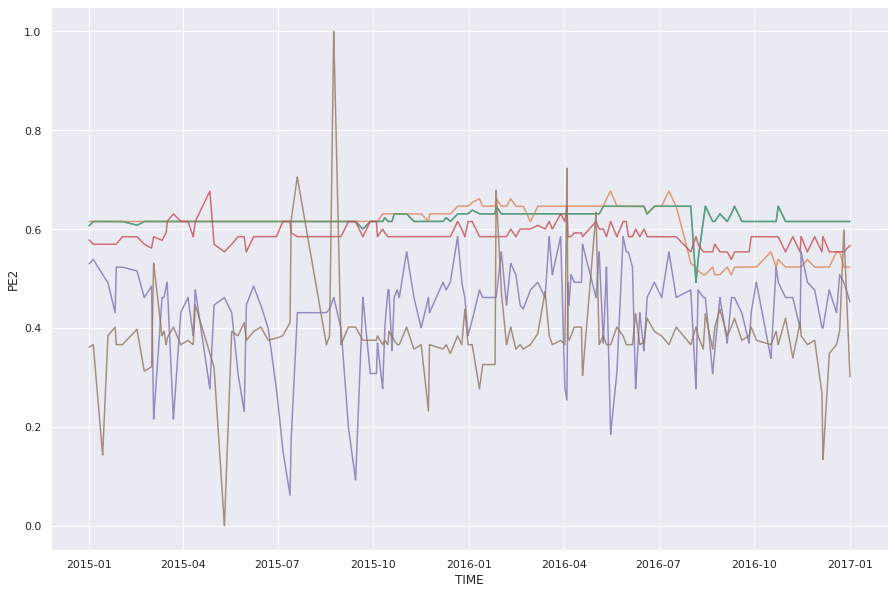

In [6]:
for col in ["PE2", "PE1",	"PE2", "PE3", "PE4", "TP1"]:
  sns.lineplot(data = manual, x = "TIME", y = col, alpha = 0.8)

Looking at the `FM1` values will help decide whether or not to **weight the loss function**.

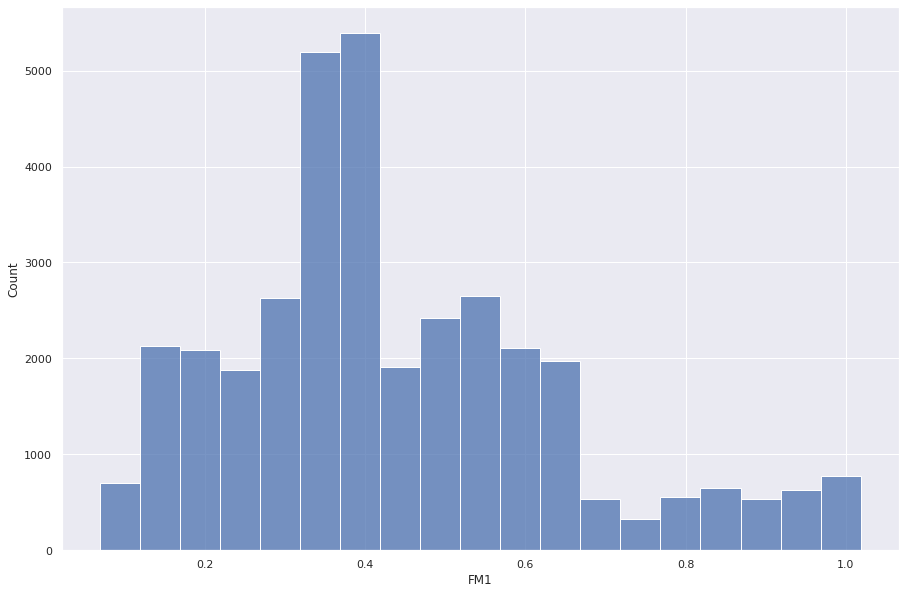

In [9]:
sns.histplot(data = manual, x = "FM1", binwidth = 0.05)

It is clear that the majority of `FM1` values are between ~0.15 and ~0.6 so they should be easier to predict given the higher volume of data in that range. Values closer to 1 will be harder as there are less examples, but there are some at the max value. So a weighted loss function will be used in training.

In [10]:
def weighted_l1_loss(inp, targ, weight_fn = None):
    """Weighted l1 loss"""
    if weight_fn is not None:
        return (F.l1_loss(*flatten_check(inp,targ), reduction = 'none') * weight_fn(targ)).mean()
    else:
        return F.l1_loss(*flatten_check(inp,targ))

def weight_fn(targ, min = 0, max = 1):
    """Weight function"""
    targ = TensorBase(targ.contiguous()).view(-1)
    weight = 1 + torch.clamp((targ - min)/(max - min), 0, 1)
    return weight

loss_func = partial(weighted_l1_loss, weight_fn = weight_fn) # Create the loss function

## **Setting up TSAI/the data**
### Sliding window
The way the data is being split is by using `SlidingWindow`. The way this works is by specifying
* `window_len` - the length of a sequence (in this case 16 is used as we want to predict 8 hours in the future and each data point is 30 minutes)
* `get_x` - the columns to use (indicies of columns used)
* `get_y` - the target column (name used)
* `stride` - how much to move the window by each time (1 is saying move along 30 minutes)
* `horizon` - how far from the last data point to predict (1 is saying to predict the next y after the 8 hour chunk)
* `ascending` - sort by ascending order
* `seq_first` - used as it's a dataframe


Visually a basic example is as such.

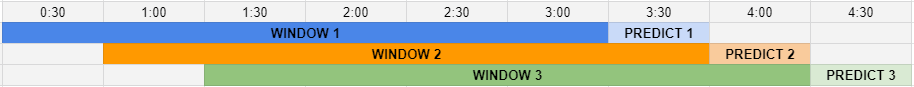

In [11]:
X, y = SlidingWindow(window_len = 16, get_x = [2, 3, 4, 5, 6], get_y = "FM1", start = 0, stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(manual) # Split into windows
X[0:2], y[0:2] # Two examples of windows, notice Xs consist of multiple arrays as there are multiple Xs (each x is a sensor input)

(array([[[0.6153846 , 0.6153846 , 0.6153846 , 0.6153846 , 0.6153846 ,
          0.6153846 , 0.6153846 , 0.6153846 , 0.6153846 , 0.6153846 ,
          0.6153846 , 0.6153846 , 0.6153846 , 0.6153846 , 0.6153846 ,
          0.6153846 ],
         [0.60663915, 0.6066849 , 0.6067308 , 0.6067766 , 0.6068224 ,
          0.60686815, 0.6069139 , 0.6069597 , 0.60700554, 0.6070513 ,
          0.6070971 , 0.60714287, 0.60718864, 0.6072344 , 0.6072802 ,
          0.60732603],
         [0.57797617, 0.5779304 , 0.5778846 , 0.5778388 , 0.577793  ,
          0.5777472 , 0.57770145, 0.5776557 , 0.5776099 , 0.5775641 ,
          0.5775183 , 0.5774725 , 0.57742673, 0.57738096, 0.5773352 ,
          0.5772894 ],
         [0.5297161 , 0.52976185, 0.5298077 , 0.52985346, 0.52989924,
          0.529945  , 0.5299908 , 0.53003657, 0.53008246, 0.53012824,
          0.530174  , 0.5302198 , 0.53026557, 0.53031135, 0.5303571 ,
          0.53040296],
         [0.36099592, 0.36102247, 0.36104906, 0.3610756 , 0.36110216

### Splits
With the data in "windows" it can now be split into training and validation datasets. It is important to not shuffle the data as the aim is to forecast the future.

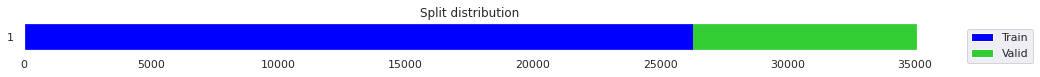

In [12]:
# Split by 75:25
# Set a seed
# Don't shuffle the splits
splits = get_splits(y, valid_size = .25, random_state = 23, shuffle = False) 

### Dataloaders

After splitting the data, dataloaders can now be created. `TSForecasting` must be declared in `tfms` given the task is to forecast `FM1`. It should also be noted that `shuffle_train` is set to `True`. The reasoning is after researching forecasting problems it is ok to shuffle the training data for this example but the validation data MUST not be shuffled.

In [13]:
tfms  = [None, TSForecasting()]
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 256, shuffle_train = True, inplace = True)

Check if the training and validation data is not/is being shuffled appropriately (it is).

In [14]:
dls.train.shuffle, dls.valid.shuffle

(True, False)

Check if it is a single output (what is required) before creating a model (it is).

In [15]:
dls.c

1

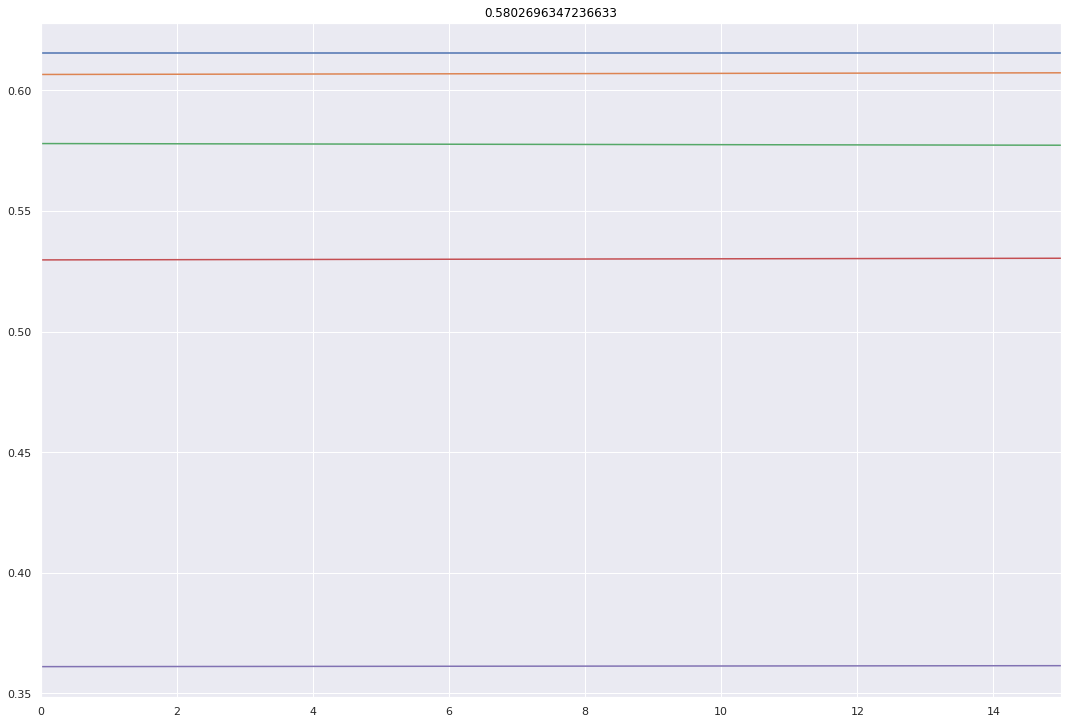

In [16]:
dls.show(dls.train_ds[0]) # A window of data and it's y (future) value

## **ResidualDynamics (created callback)**
`tsai` recently added a fastai callback called `PredictionDynamics` being inspired by *Andrej Karpathy*. After each epoch it plots the ground truth against the current predictions showing how predictions change over each epoch.

I liked this idea and made a callback very similar to it but rather than ground truth and prediction it shows ground truth and residuals after each epoch and at the end. For this particular problem I've found error metrics such as `mae` not being useful to evaluate the model's performance given there are a lot of data points. I prefer to see where the model is over/underpredicting and if it does so for a large volume of data.

In [17]:
class ResidualDynamics(Callback):
    order, run_valid = 65, True

    def __init__(self, figsize = (6, 6), alpha = .3, size = 30, color = 'aqua', cmap = 'gist_rainbow'):
        store_attr("figsize, alpha, size, color, cmap")

    def before_fit(self):
        """Called before doing anything, ideal for initial setup."""
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run:
            return

        # Prepare ground truth container, set here as y_true's always stay the same
        self.y_true = []

    def before_epoch(self):
        """Called at the beginning of each epoch, useful for any behavior you need to reset at each epoch."""

        # Prepare prediction container in every epoch, set/reset here as new predictions are obtained after each epoch as NN learns
        self.y_pred = []

    def after_pred(self):
        """Called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss."""
        # If training then skip
        if self.training:
            return

        # Get ground truths in epoch 0 i.e. start of training
        if self.epoch == 0:
            self.y_true.extend(self.y.cpu().flatten().numpy())

        # Get predictions from each batch and add them to prediction container
        y_pred = self.pred.detach().cpu()
        
        self.y_pred.extend(y_pred.flatten().numpy())

    def after_epoch(self):
        """Called at the end of an epoch, for any clean-up before the next one."""

        self.y_true = np.array(self.y_true)                                     # Ground truths
        self.y_pred = np.array(self.y_pred)                                     # Predictions for this epoch
        self.residuals = self.y_true - self.y_pred                              # Residuals for this epoch
        self.x_bounds = (np.min(self.y_true), np.max(self.y_true))              # x bounds for the graph (min and max of ground truths)
        self.y_bounds = (-np.max(self.residuals), np.max(self.residuals))       # y bounds for the graph (max residual either side of 0)
        
        # Update the graph with this epoch's "data"
        self.update_graph(residuals = self.residuals, 
                          y_true = self.y_true, 
                          x_bounds = self.x_bounds, 
                          y_bounds = self.y_bounds)

    def after_fit(self):
        """Called at the end of training, for final clean-up."""
        plt.close(self.graph_ax.figure)

    def update_graph(self, residuals, y_true, x_bounds = None, y_bounds = None):
        """Called at the end of an epochs ones ground truths, preds, residuals and x and y bounds are calculated (see above)"""

        # If no graph in place then great dataframe to output and graph related objects
        if not hasattr(self, 'graph_fig'):
            self.df_out = display("", display_id = True)
            self.graph_fig, self.graph_ax = plt.subplots(1, figsize = self.figsize)
            self.graph_out = display("", display_id = True)
        
        # Clear any graphs
        self.graph_ax.clear()

        # Plotting the residuals and formatting
        self.graph_ax.scatter(x = y_true, y = residuals, color = self.color, edgecolor = 'black', alpha = self.alpha, s = self.size)
        self.graph_ax.set_xlim(*x_bounds)
        self.graph_ax.set_ylim(*y_bounds)
        self.graph_ax.plot([*x_bounds], [0, 0], color = 'gainsboro')
        self.graph_ax.set_xlabel('y_true', fontsize = 12)
        self.graph_ax.set_ylabel('residuals', fontsize = 12)
        self.graph_ax.grid(color = 'gainsboro', linewidth = .2)
        self.graph_ax.set_title(f'Residuals \nepoch: {self.epoch +1}/{self.n_epoch}')

        # Output metrics
        self.df_out.update(pd.DataFrame(np.stack(self.learn.recorder.values)[-1].reshape(1,-1),
                                        columns=self.learn.recorder.metric_names[1:-1], index=[self.epoch]))
        self.graph_out.update(self.graph_ax.figure)

## **Baseline model**
With everything setup a `ts_learner` can be created with inputs:
* The dataloaders - `dls`
* Model architecture - `InceptionTimePlus` (+ parameters `c_in`, `c_out`, `y_range`)
* Metrics - `mae` (important here as y's are between 0 and 1)

`InceptionTimePlus` is a neural network architecture that is commonly used for time series. The architecture has been implemented in `tsai` and is preferred for the baseline given you can specify the range of y values using `y_range`.

In [18]:
learn = ts_learner(dls, InceptionTimePlus, metrics = mae, loss_func = loss_func, c_in = 5, c_out = 1, y_range = [0, 1]) # Create learner

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.737800812406931e-05)

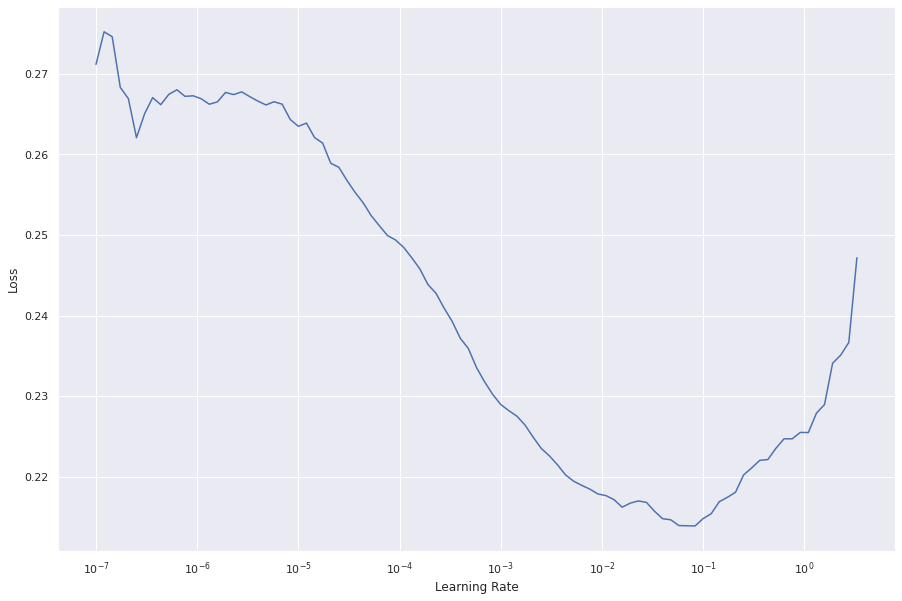

In [19]:
learn.lr_find() # Find suitable lr

epoch,train_loss,valid_loss,mae,time
0,0.268285,0.128371,0.090912,00:02


,train_loss,valid_loss,mae
0,0.268285,0.128371,0.090912


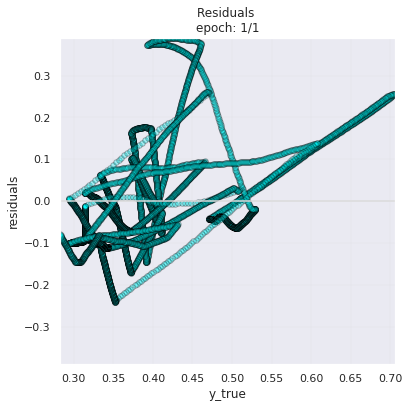

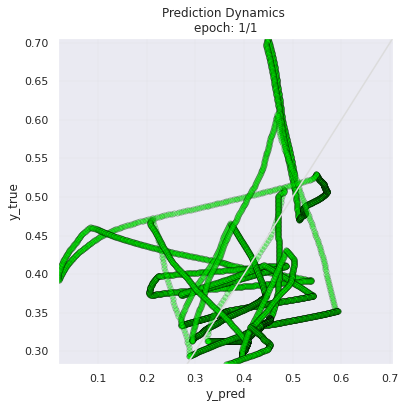

,train_loss,valid_loss,mae
0,0.268285,0.128371,0.090912


epoch,train_loss,valid_loss,mae,time
0,0.267944,0.136698,0.097128,00:02
1,0.268090,0.137295,0.097598,00:02
2,0.265531,0.138080,0.098165,00:02
3,0.263020,0.138971,0.098902,00:02
4,0.262037,0.140424,0.100048,00:02
5,0.260304,0.146241,0.104513,00:02
6,0.257030,0.148557,0.106280,00:02
7,0.251944,0.149328,0.106908,00:02
8,0.249191,0.152686,0.109469,00:02
9,0.247781,0.153834,0.110407,00:02


,train_loss,valid_loss,mae
24,0.236026,0.138495,0.099201


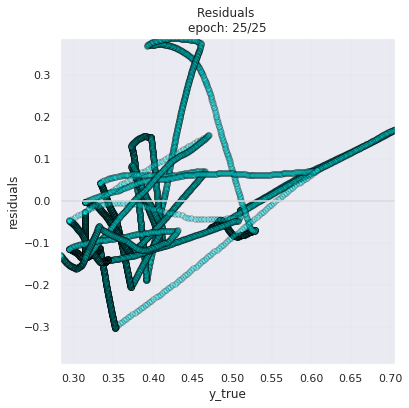

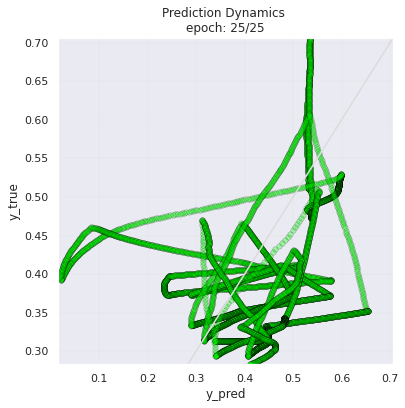

,train_loss,valid_loss,mae
24,0.236026,0.138495,0.099201


In [20]:
# Training loop
# - Fit for 25 epochs
# - Learning rate at 1e-5 (decreasing over time)
# - Use PredictionDynamics callback to see the predicted vs truths after each epoch/at the end of training
# - Use ResidualDynamics to see how residuals are after each epoch/at the end of the training
# - Add a tiny bit of weight decay to lessen overfitting
learn.fine_tune(25, 1e-5, cbs = [PredictionDynamics, ResidualDynamics], wd = 0.05)

So `mae` of ~0.15 could potentially be good but given this problem has y values ranging from 0 to 1 that isn't good. Residual plots can be useful to see how the model performs across the different ranges of values. 

In the context of the problem it is better to **overpredict** `FM1` given we want to catch high flow rates before they get out of control.

## **Test with using previous flow rate to predict flow rate**
Rather than using other sensory inputs an alternative approach can be to use previous flow rates to predict the next flow rate. This can be done by replacing `get_x` with `FM1` and making sure horizon is set to 0+. Again splits and dataloaders can be created.

In [21]:
X, y = SlidingWindow(window_len = 16, get_x = "FM1", get_y = "FM1", start = 0, stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(manual) # Split into windows
X[0:2], y[0:2] # Two examples of windows, notice Xs consist of one array as only FM1 not multiple sensors

(array([[[0.5732668 , 0.5737045 , 0.57414216, 0.57457983, 0.5750175 ,
          0.5754552 , 0.57589287, 0.5763305 , 0.5767682 , 0.5772059 ,
          0.5776435 , 0.57808125, 0.5785189 , 0.57895654, 0.5793942 ,
          0.57983196]],
 
        [[0.5737045 , 0.57414216, 0.57457983, 0.5750175 , 0.5754552 ,
          0.57589287, 0.5763305 , 0.5767682 , 0.5772059 , 0.5776435 ,
          0.57808125, 0.5785189 , 0.57895654, 0.5793942 , 0.57983196,
          0.58026963]]]), array([0.58026963, 0.58070725]))

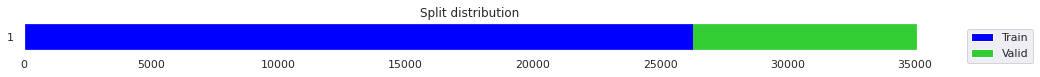

In [22]:
splits = get_splits(y, valid_size = .25, random_state = 23, shuffle = False) # Split

In [26]:
tfms  = [None, TSForecasting()]
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 512, shuffle_train = True, inplace = True)

### Model
I've changed the model hear after some experiementation with InceptionTime architectures. This input data worked better with `InceptionTimePlus` which is similar to `InceptionTime` but it has a few more inputs, specifically setting the target range using `y_range`. However this architecture didn't work well with the other input data.

In [27]:
learn = ts_learner(dls, InceptionTimePlus, metrics = mae, loss_func = loss_func, c_in = 1, c_out = 1, y_range = [0, 1])

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=6.30957365501672e-05)

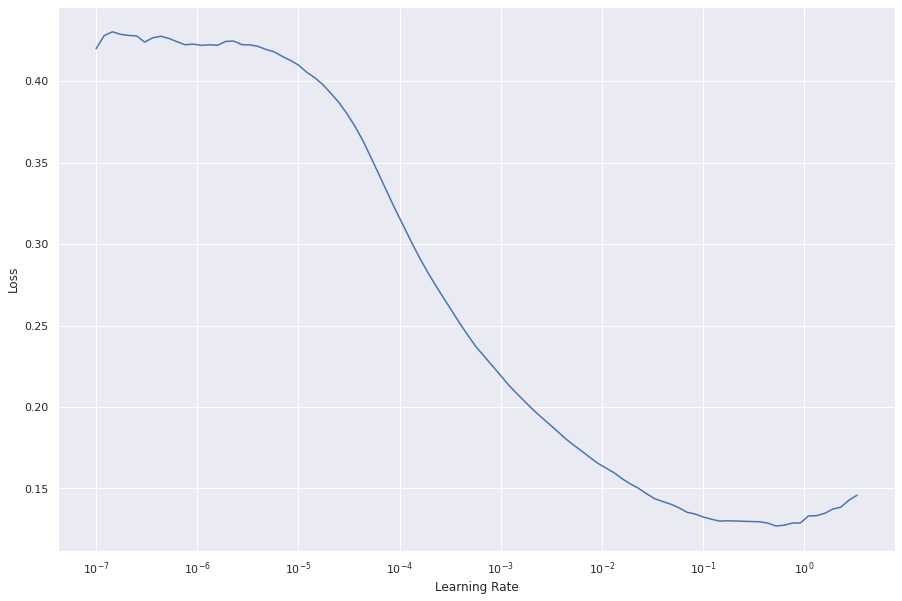

In [28]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.202640,0.042074,0.029665,00:01
1,0.075824,0.012124,0.008705,00:01


,train_loss,valid_loss,mae
1,0.075824,0.012124,0.008705


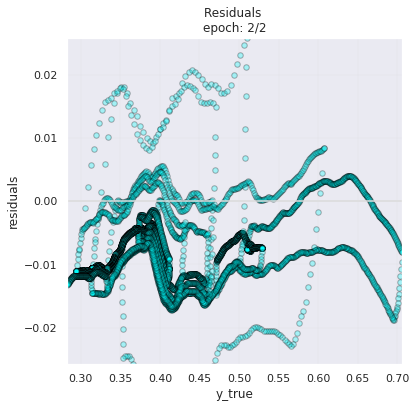

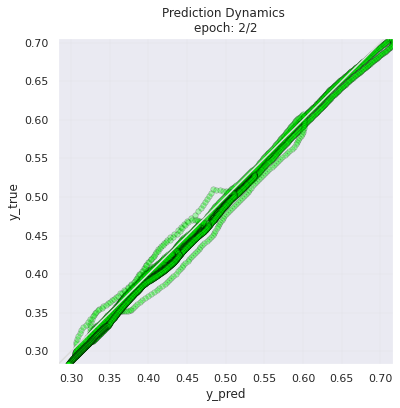

,train_loss,valid_loss,mae
1,0.075824,0.012124,0.008705


epoch,train_loss,valid_loss,mae,time
0,0.018115,0.005820,0.004052,00:01
1,0.018187,0.006005,0.004253,00:01
2,0.017810,0.007489,0.005051,00:01
3,0.018462,0.006873,0.004808,00:01
4,0.018754,0.013633,0.009531,00:01
5,0.018906,0.010119,0.007089,00:01
6,0.018015,0.012318,0.008601,00:01
7,0.019110,0.007938,0.005372,00:01
8,0.019079,0.006159,0.004373,00:01
9,0.016359,0.005866,0.004224,00:01


,train_loss,valid_loss,mae
24,0.009541,0.001712,0.001191


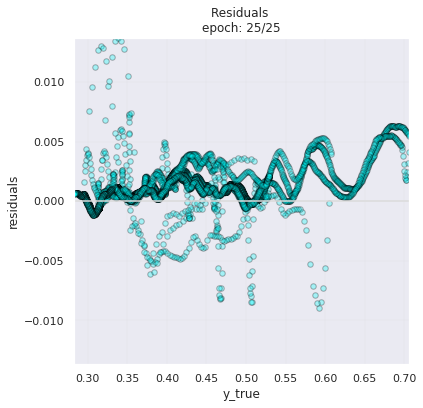

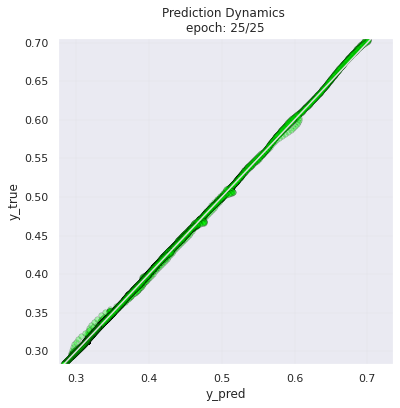

,train_loss,valid_loss,mae
24,0.009541,0.001712,0.001191


In [29]:
learn.fine_tune(25, 5e-3, freeze_epochs = 2, cbs = [PredictionDynamics, ResidualDynamics], wd = 0.01)

Both losses have decreased with no obvious signs of overfitting! With an alternative approach the results have been improved significantly with a large decrease to residuals. If we're being critical the model appears to primarily overpredict.

## **Closing thoughts**
Although there are more traditional forecasting methods e.g. moving average, neural networks can be powerful and quick to train for similar tasks. Even using a fairly simplistic idea of taking previous values of the target in a "window" of time, the results can be high performing.

There's a lot to explore with `tsai` e.g. calculating an Y's using a function such as take the max value of the next 5 time steps and predict that per window, this is a basic example. This problem could even be turned into a classification problem if you know a threshold for when `FM1` is problematic.